<a href="https://colab.research.google.com/github/nurimammasri/Dicoding-Belajar-Pengembangan-Machine-Learning/blob/main/Submission%2001/Additional/Submission%2001%20-%20Emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import string
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir /root/.kaggle/
! cp "/content/drive/My Drive/Machine Learning/kaggle.json" /root/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=89bee8e14b4bc7451a18b1fb9553b92be61699c449e058ab6740d190b561aeb4
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [ ]:
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

emotions-dataset-for-nlp.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
zip_ref = zipfile.ZipFile('emotions-dataset-for-nlp.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
df_train = pd.read_csv('train.txt', names=['sentence', 'label'], sep=';')
df_test = pd.read_csv('test.txt', names=['sentence', 'label'], sep=';')
df_val = pd.read_csv('val.txt', names=['sentence', 'label'], sep=';')

In [ ]:
df = df_train.append(df_test)
df = df.append(df_val)
df

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


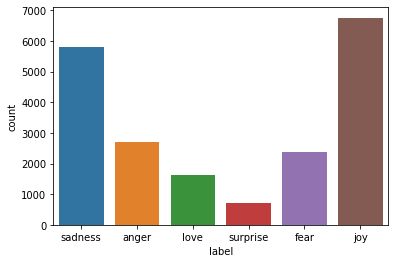

In [ ]:
sns.countplot(df['label'])

17442


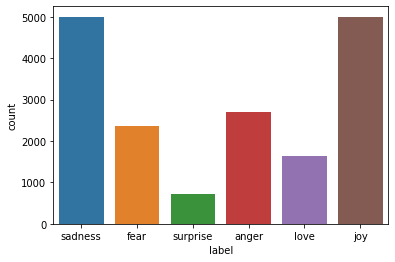

In [ ]:
balance_length = 5000

df_sadness = df[df['label']=='sadness']
df_fear = df[df['label']=='fear']
df_surprise = df[df['label']=='surprise']
df_anger = df[df['label']=='anger']
df_love = df[df['label']=='love']
df_joy = df[df['label']=='joy']

new_df = df_sadness[:balance_length]
new_df = new_df.append(df_fear)
new_df = new_df.append(df_surprise)
new_df = new_df.append(df_anger)
new_df = new_df.append(df_love)
new_df = new_df.append(df_joy[:balance_length])


# new_df = df
print(len(new_df))

sns.countplot(new_df['label'])

In [ ]:
category = pd.get_dummies(new_df['label'])
new_df = pd.concat([new_df, category], axis=1)
new_df = new_df.drop(columns='label')
new_df

,sentence,anger,fear,joy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
5,ive been feeling a little burdened lately wasn...,0,0,0,0,1,0
10,i feel like i have to make the suffering i m s...,0,0,0,0,1,0
13,i feel low energy i m just thirsty,0,0,0,0,1,0
...,...,...,...,...,...,...,...
14870,i feel sometimes like i want to say things tha...,0,0,1,0,0,0
14874,ive learned not to depend on nor expect my bod...,0,0,1,0,0,0
14875,i feel kinda mellow though i think that time o...,0,0,1,0,0,0
14878,i went blonde i was feeling adventurous and a ...,0,0,1,0,0,0


In [ ]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

puncts = string.punctuation
replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '£']

print(sw)

custom_sw = list(set([word.replace("'", "") for word in sw]))
print(custom_sw)

sw = custom_sw+sw
sw = list(set(sw))
sw.sort()
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def clean_text(text):
  text = str(text)
  text_stopword = [word.lower() for word in text.split() if word.lower() not in sw and len(word.lower()) > 2]  #  
  text_stopword = " ".join(text_stopword)

  x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", text_stopword)
  
  for key, value in replace_puncts.items():
    x = x.replace(key, f' {value} ')

  for punct in strip_chars:
    x = x.replace(punct, ' ') 
    
  for punct in puncts:
    x = x.replace(punct, f' {punct} ')
  
  x = x.replace(" '", " ")
  x = x.replace("' ", " ")
  x = x.strip()
  return x

def lemm(text):    
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(text)

def text_processing(X):
    X=X.apply(clean_text)
    X=X.apply(lemm)
    return X

In [ ]:
x = text_processing(new_df['sentence'])
y = new_df[['anger', 'fear',	'joy',	'love',	'sadness',	'surprise']].values

x_clean = x.values
x_clean

array(['feel humiliated',
       'feeling hopeless damned hopeful around someone care awake',
       'ive feeling little burdened lately sure', ...,
       'feel kinda mellow though think time month going turn raging bitch moment last night felt totally angry like cranky really restless',
       'went blonde feeling adventurous little lost person',
       'cant stop feeling delighted'], dtype=object)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_clean, y, test_size=0.2, random_state = 42)

In [ ]:
tokenizer2 = Tokenizer(oov_token='<OOV>')
tokenizer2.fit_on_texts(x_train)

print(tokenizer2.word_index)
print(len(tokenizer2.word_index))

{'<OOV>': 1, 'feel': 2, 'feeling': 3, 'like': 4, 'time': 5, 'really': 6, 'know': 7, 'get': 8, 'little': 9, 'make': 10, 'day': 11, 'people': 12, 'thing': 13, 'want': 14, 'one': 15, 'would': 16, 'life': 17, 'think': 18, 'ive': 19, 'still': 20, 'even': 21, 'bit': 22, 'way': 23, 'something': 24, 'love': 25, 'going': 26, 'much': 27, 'could': 28, 'need': 29, 'back': 30, 'good': 31, 'always': 32, 'say': 33, 'right': 34, 'also': 35, 'pretty': 36, 'see': 37, 'work': 38, 'friend': 39, 'year': 40, 'today': 41, 'cant': 42, 'around': 43, 'made': 44, 'help': 45, 'got': 46, 'someone': 47, 'come': 48, 'felt': 49, 'well': 50, 'never': 51, 'though': 52, 'thought': 53, 'look': 54, 'lot': 55, 'le': 56, 'quite': 57, 'week': 58, 'every': 59, 'kind': 60, 'away': 61, 'happy': 62, 'enough': 63, 'many': 64, 'find': 65, 'sure': 66, 'anything': 67, 'take': 68, 'ever': 69, 'without': 70, 'sometimes': 71, 'home': 72, 'everything': 73, 'left': 74, 'getting': 75, 'better': 76, 'world': 77, 'started': 78, 'last': 79, 

In [ ]:
max_len = 35
num_words = 5000  # 1000, 2000, 5000, 10000
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

tokenizer.word_index = {e:i for e, i in tokenizer.word_index.items() if i <= num_words}
word_index = tokenizer.word_index
print(word_index)
print(len(word_index))

sequence_train = tokenizer.texts_to_sequences(x_train)
sequence_test = tokenizer.texts_to_sequences(x_test)

padded_train = pad_sequences(sequence_train, padding='post', maxlen=max_len, truncating='post')
padded_test = pad_sequences(sequence_test, padding='post', maxlen=max_len, truncating='post')

print(len(padded_train[0]))
print(len(padded_test[0]))

{'<OOV>': 1, 'feel': 2, 'feeling': 3, 'like': 4, 'time': 5, 'really': 6, 'know': 7, 'get': 8, 'little': 9, 'make': 10, 'day': 11, 'people': 12, 'thing': 13, 'want': 14, 'one': 15, 'would': 16, 'life': 17, 'think': 18, 'ive': 19, 'still': 20, 'even': 21, 'bit': 22, 'way': 23, 'something': 24, 'love': 25, 'going': 26, 'much': 27, 'could': 28, 'need': 29, 'back': 30, 'good': 31, 'always': 32, 'say': 33, 'right': 34, 'also': 35, 'pretty': 36, 'see': 37, 'work': 38, 'friend': 39, 'year': 40, 'today': 41, 'cant': 42, 'around': 43, 'made': 44, 'help': 45, 'got': 46, 'someone': 47, 'come': 48, 'felt': 49, 'well': 50, 'never': 51, 'though': 52, 'thought': 53, 'look': 54, 'lot': 55, 'le': 56, 'quite': 57, 'week': 58, 'every': 59, 'kind': 60, 'away': 61, 'happy': 62, 'enough': 63, 'many': 64, 'find': 65, 'sure': 66, 'anything': 67, 'take': 68, 'ever': 69, 'without': 70, 'sometimes': 71, 'home': 72, 'everything': 73, 'left': 74, 'getting': 75, 'better': 76, 'world': 77, 'started': 78, 'last': 79, 

In [ ]:
token_test = ["i feel nothing right now"]
print(tokenizer.texts_to_sequences(token_test))

[[1, 2, 109, 34, 1]]


In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(num_words, 128, input_length=max_len),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences = True,recurrent_dropout=0.5)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.GlobalMaxPool1D(),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 35, 128)           640000    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 35, 200)           183200    
_________________________________________________________________
dropout_32 (Dropout)         (None, 35, 200)           0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                12864     
_________________________________________________________________
dropout_33 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 6)               

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy') > 0.915:
      print("\nAkurasi telah mencapai > 91.5%")
      self.model.stop_training = True


callbacks = MyCallback()

es=EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
num_epochs = 10
history = model.fit(
    padded_train,
    y_train,
    epochs=num_epochs,
    validation_data=(padded_test, y_test),
    callbacks=[es, callbacks]
)

Epoch 1/10
437/437 [==============================] - 160s 366ms/step - loss: 1.0629 - accuracy: 0.5873 - val_loss: 0.3576 - val_accuracy: 0.9120
Epoch 2/10
437/437 [==============================] - 164s 375ms/step - loss: 0.2090 - accuracy: 0.9248 - val_loss: 0.2546 - val_accuracy: 0.9152
Epoch 3/10
437/437 [==============================] - 161s 369ms/step - loss: 0.1169 - accuracy: 0.9568 - val_loss: 0.2365 - val_accuracy: 0.9129
Epoch 4/10
437/437 [==============================] - 162s 371ms/step - loss: 0.0807 - accuracy: 0.9694 - val_loss: 0.2145 - val_accuracy: 0.9163
Epoch 5/10
437/437 [==============================] - 165s 377ms/step - loss: 0.0683 - accuracy: 0.9754 - val_loss: 0.2316 - val_accuracy: 0.9069
Epoch 6/10
437/437 [==============================] - 165s 377ms/step - loss: 0.0550 - accuracy: 0.9796 - val_loss: 0.2326 - val_accuracy: 0.9080


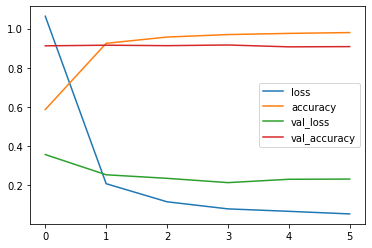

In [ ]:
losses=pd.DataFrame(model.history.history)
losses.plot()

In [ ]:
pred = [["yeay i got 5 stars in this submission"], 
        ["shut your mouth"], ["please don't touch me"],
        ["i feel empty"], ["i feeling so dazed today"],
        ["i'm so surprise you will come here tonight"]]

for text in pred:
  sequences_pred = tokenizer.texts_to_sequences(text)
  padded_pred = pad_sequences(sequences_pred, padding='post', maxlen=max_len, truncating='post')
  classes = model.predict(padded_pred)

  label = ['anger', 'fear', 'joy',	'love',	'sadness',	'surprise']
  print(text)
  print(classes)
  print(label[np.argmax(classes)])
  print()


['yeay i got 5 stars in this submission']
[[0.13595983 0.07385553 0.5879977  0.0761933  0.05703904 0.06895464]]
joy

['shut your mouth']
[[0.28934526 0.21516103 0.09617338 0.08328456 0.21951297 0.09652276]]
anger

["please don't touch me"]
[[0.13966739 0.543942   0.0785813  0.06571334 0.07838663 0.09370935]]
fear

['i feel empty']
[[3.4199029e-04 5.5287342e-04 1.0184471e-03 1.8919075e-04 9.9785280e-01
  4.4775981e-05]]
sadness

['i feeling so dazed today']
[[2.11526189e-04 2.54812688e-02 1.35342935e-02 1.64874131e-04
  8.63619149e-04 9.59744453e-01]]
surprise

["i'm so surprise you will come here tonight"]
[[0.06358587 0.05265281 0.37591255 0.44719929 0.02789211 0.03275743]]
love

